# Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../src')

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [6]:
def plot(y_pred, y_true):
    sns.set_style("darkgrid")
    plt.plot(y_true, color='green',label="True")        
    plt.plot(y_pred, color='blue', label="Prediction")
    plt.legend()
    plt.show()

## Setup

In [7]:
sns.set(rc = {'figure.figsize':(15,8)})

In [8]:
VARIABLE       = 'temp' # 'close'
DATASET_1_PATH = '../datasets/ETH_1H.csv'
DATASET_2_PATH = '../datasets/daily-min-temperatures.csv'

## Preprocessing

In [9]:
def preprocessing(dataset, column, test_percent):
    dataset.columns = dataset.columns.str.lower()
    dataset       = dataset[['date', column]]
    dataset       = dataset.rename(columns={'date': 'ds', column: 'y' })
    dataset['ds'] = pd.to_datetime(dataset['ds'])
    dataset       = dataset.sort_values(by='ds',ascending=True)
    
    train_set, test_set           = train_test_split(dataset, test_percent = test_percent)
    norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=['y'])
    
    norm_train_set = norm_train_set[['ds', 'norm_y']]
    norm_train_set = norm_train_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)
    
    norm_test_set = norm_test_set[['ds', 'norm_y']]
    norm_test_set = norm_test_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)

    print(norm_train_set.shape, norm_test_set.shape)

    return norm_train_set, norm_test_set

In [14]:
dataset = pd.read_csv(DATASET_2_PATH)

train_set, test_set = preprocessing(dataset, VARIABLE, test_percent = 0.1)

# train_set.info()

(3285, 2)
(365, 2)

In [15]:
# train_set.tail()

In [16]:
# test_set.head()

# Model Definition

In [17]:
model = Prophet(
    interval_width=0.99, 
    daily_seasonality=True
)
model.fit(train_set)

10:12:02 - cmdstanpy - INFO - Chain [1] start processing
10:12:03 - cmdstanpy - INFO - Chain [1] done processing


<prophet.forecaster.Prophet object at 0x7f257b282ec0>

<Figure size 1080x576 with 1 Axes>

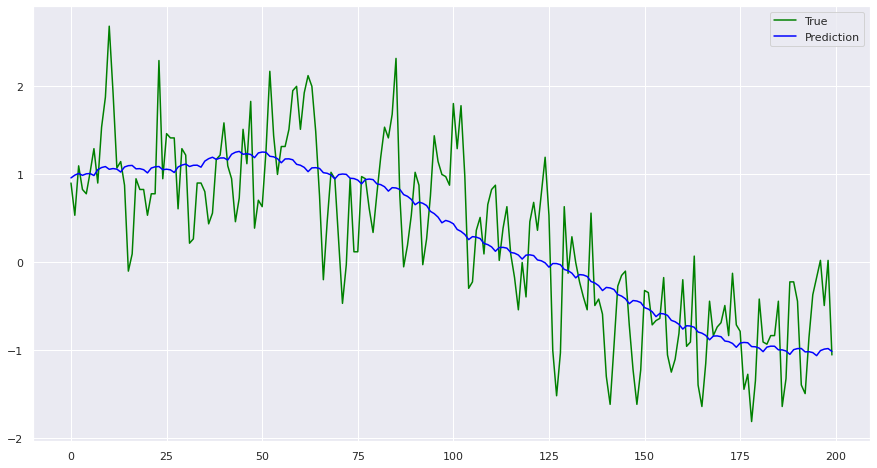

<Figure size 720x432 with 1 Axes>

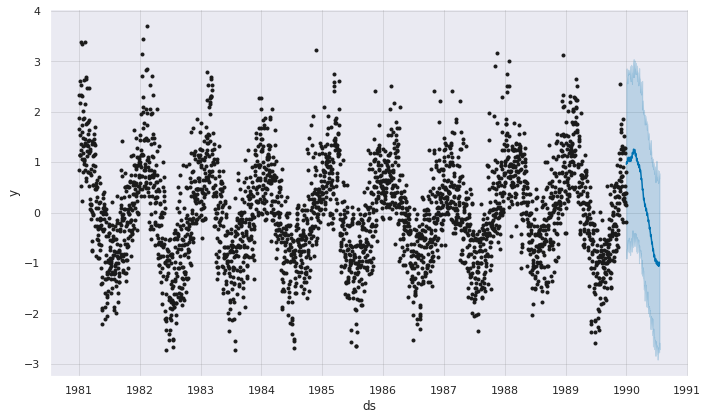

<Figure size 720x432 with 1 Axes>

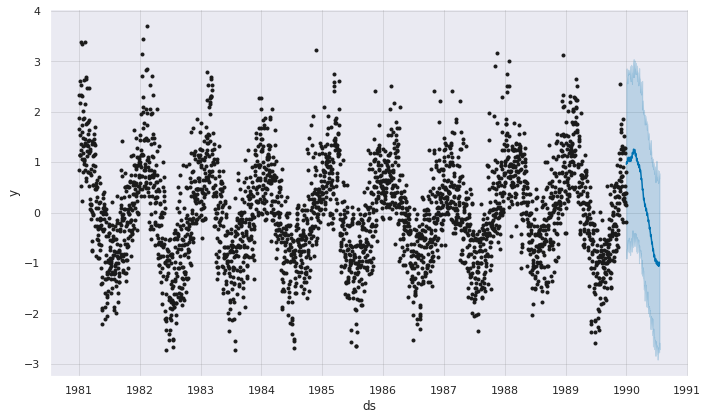

In [20]:
predict_df = test_set.head(200)
forecast = model.predict(predict_df[['ds']])
results = predict_df.merge(forecast, on='ds')

results = results[['ds', 'y', 'yhat']].sort_values(by='ds',ascending=True)
plot(results.yhat.values, results.y.values)
model.plot(forecast)